# Analysis of mean- and fluctuation-driven contributions to dynamics

$$\Theta^{t+1} = \left[\alpha_1(\Theta^t), \dots, \alpha_R(\Theta^t)\right]^T$$

$$\alpha_r = 
\int_{x}\mathcal{N}\left(x; \mu_r, \sigma_r\right) \prod_{r'\neq r} \Phi\left(x; \mu_{r'}, \sigma_{r'}\right)$$

$$\mu_r = R \sum_{r'} \mu_{rr'} \Theta_{r'}^t + u_r^t$$

$$\sigma^2_r = R \sum_{r'} \gamma_{rr'}^2 \Theta_{r'}^t + v_r^t$$

Start by decomposing the next state $\Theta^{t+1}$ into mean and fluctuation-driven terms:

$$\Theta^{t+1} = \Theta_{\mu}^{t+1} + \Theta_{\sigma}^{t+1}$$

where $\Theta_{\mu}^{t+1}$ is the state that would have been produced by mean-driven dynamics alone, i.e. with all $\sigma_r = 0$ and $\Theta_{\sigma}$ is simply defined by

$$\Theta_{\sigma}^{t+1} = \Theta^{t+1} - \Theta_{\mu}^{t+1}$$

The mean-driven term is given by

$$
\left(\Theta_{\mu}^{t+1}\right)_r = \int_x \mathcal{N}(x; \mu_r, 0)\prod_{r' \neq r} \Phi(x; \mu_{r'}, 0)
= \mathbb{1}\left[\mu_r \geq \mu_1, \dots, \mu_r \geq \mu_R\right]
$$

or 

$$\Theta_{\mu}^{t+1} = \mathbf{e}_{\text{argmax}(\{\mu_r\})}$$

where $\mathbf{e}_{\text{argmax}(\{\mu_r\})}$ is the one-hot vector corresponding to the largest mean input, also corresponding to the $r$-th corner of the simplex $\mathbb{S}_R$ on which the dynamics evolve.

Thus, at every timestep, the mean-driven term has the effect of pushing the system state to one corner of the simplex, although which particular corner that is can change over time.

## Role of input fluctuations

When fluctuations are non-zero however, $\Theta^{t+1}$ is not in general confined to the corners. Thus, fluctuations counteract the saturating effect of the mean inputs and slow down the dynamics to allow the system state to traverse the interior of the simplex.

This can be understood graphically. At each time step the full $R$-dim input distribution $P^t(\mathbf{x})$ is a Gaussian with diagonal covariance, but variable individual variances. If one partitions $\mathbb{R}^R$ into $R$ regions defined by which coordinate is largest, then $\Theta^{t+1}$ is given by how much of $P^t(\mathbf{x})$ is contained in each partition.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys

from disp import set_plot

In [2]:
# numeric params for computing MF quantities
DX = .001
X_MIN = -10
X_MAX = 10

X = np.linspace(X_MIN, X_MAX, int((X_MAX-X_MIN)/DX)+1)

def norm(x, mu, sgm):
    return stats.norm.pdf(x, loc=mu, scale=sgm)

def phi(x, mu, sgm):
    return stats.norm.cdf(x, loc=mu, scale=sgm)

def alph_int(mu_r, sgm_r):
    
    R = len(mu_r)
    
    phis = np.array([phi(X, mu_r_, sgm_r_) for mu_r_, sgm_r_ in zip(mu_r, sgm_r)])
    
    mnot_r = ~np.eye(R, dtype=bool) # masks for selecting all but one r
    
    th_next = np.nan*np.zeros(R)
    for r, (mu_r_, sgm_r_) in enumerate(zip(mu_r, sgm_r)):
        
        mask_r = mnot_r[r]
        th_next[r] = np.sum(norm(X, mu_r_, sgm_r_) * np.prod(phis[mask_r, :], axis=0))*DX
        
    return th_next

def alph(th, u, v, R, mu_j, sgm_j):
    """
    th \in [0, 1]^R
    u \in R^R
    v \in R_+^r
    R scalar
    mus \in R^{RxR}
    gams \in R^{RxR}
    """
    mu_r = R*(mu_j @ th) + u
    sgm_r = np.sqrt(R*((sgm_j**2)@th) + v)
    
    th_next = alph_int(mu_r, sgm_r)
    
    return th_next

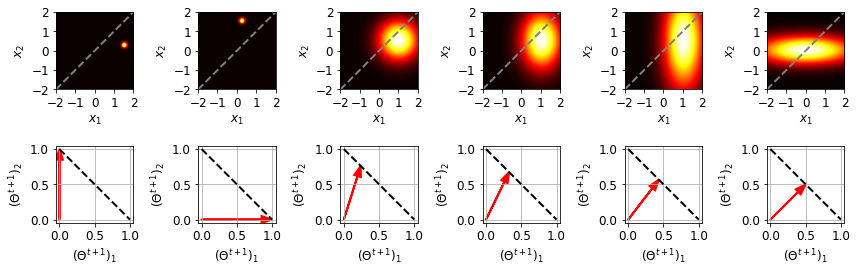

In [3]:
MUS_SGMS = [
    [(.25, 1.5), (.01, .01)],
    [(1.5, .25), (.01, .01)],
    [(.5, 1), (.5, .5)],
    [(.5, 1), (1, .5)],
    [(.5, 1), (3, .5)],
    [(0, 0), (.25, 3)],
]

x_1, x_2 = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.dstack((x_1, x_2))

fig, axs = plt.subplots(2, len(MUS_SGMS), figsize=(2*len(MUS_SGMS), 4), tight_layout=True)

for (mu_r, sgm_r), ax_row in zip(MUS_SGMS, axs.T):
    rv = stats.multivariate_normal(mu_r, np.diag(sgm_r)) 
    
    ax_row[0].plot([-2, 2], [-2, 2], color='gray', ls='--', lw=2)
    ax_row[0].matshow(rv.pdf(pos), extent=[-2, 2, -2, 2], origin='lower', cmap='hot')
    ax_row[0].set_aspect('equal')
    ax_row[0].xaxis.tick_bottom()
    set_plot(ax_row[0], x_label=r'$x_1$', y_label=r'$x_2$')
    
    th_next = alph_int(mu_r, sgm_r)
    ax_row[1].arrow(0, 0, th_next[0], th_next[1], color='r', length_includes_head=True, head_width=.1, lw=2)
    ax_row[1].plot([0, 1], [1, 0], c='k', ls='--', lw=2)
    ax_row[1].grid()
    ax_row[1].set_aspect('equal')
    set_plot(ax_row[1], x_lim=(-.05, 1.05), y_lim=(-.05, 1.05), x_ticks=(0, .5, 1), y_ticks=(0, .5, 1), x_label=r'$(\Theta^{t+1})_1$', y_label=r'$(\Theta^{t+1})_2$')